### Imports
при подготовке семинара использованы материалы курса "Машинное обучения" от АТП ФИВТ МФТИ

In [228]:
from collections import Counter, defaultdict
from copy import deepcopy
from operator import itemgetter
from random import shuffle

import numpy as np
import pandas as pd
import scipy
from matplotlib import pylab, gridspec, pyplot as plt
from IPython.display import Image
import urllib
import seaborn as sns


from sklearn.metrics import accuracy_score
from sklearn import metrics, neighbors, dummy, preprocessing, svm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier


import matplotlib
%matplotlib inline

-------
<h1 align="center"> Работа с признаками </h1> 
# Предобработка данных
скачайте данные с помощью pd.read_csv по ссылке https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data и уберите заголовок

In [229]:
# Используются данные из https://archive.ics.uci.edu/ml/datasets/Adult
df = pd.read_csv('adult.csv')
columns = ('age workclass fnlwgt education educ-num marital-status occupation relationship '
           'race sex capital-gain capital-loss  hours-per-week native-country salary')
df.columns = columns.split() #этот метод разделит датасет по колонкам как в массиве columns

выведите первые 5 записей

In [230]:
#тут ваш код
df.head()

,age,workclass,fnlwgt,education,educ-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


выведите последние 10 записей

In [231]:
#тут ваш код
df.head(10)    

,age,workclass,fnlwgt,education,educ-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
5,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
6,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
7,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
8,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K
9,37,Private,280464,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,Black,Male,0,0,80,United-States,>50K


сформируйте новый датафрейм, состоящий из стоблцов 'age, salary'. Подумайте, как можно визуализировать эту информацию при помощи графиков?

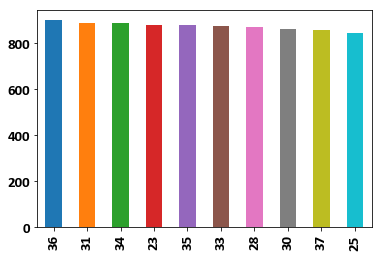

In [232]:
df2 = df[['age', 'salary']]
df2.age.value_counts()[:10].plot(kind='bar')

** Соотношение классов **

In [233]:
df.groupby('salary').count()[['age']]

,age
salary,
<=50K,24719
>50K,7841


In [234]:
df.head()

,age,workclass,fnlwgt,education,educ-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


### Перекодировка категориальных признаков

In [235]:
def number_encode_features(init_df):
    result = init_df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = preprocessing.LabelEncoder()
            encoders[column].fit(result[column])
            result[column] = encoders[column].transform(result[column])
    return result, encoders

encoded_data, encoders = number_encode_features(df)
encoded_data.head(10)

,age,workclass,fnlwgt,education,educ-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,50,6,83311,9,13,2,4,0,4,1,0,0,13,39,0
1,38,4,215646,11,9,0,6,1,4,1,0,0,40,39,0
2,53,4,234721,1,7,2,6,0,2,1,0,0,40,39,0
3,28,4,338409,9,13,2,10,5,2,0,0,0,40,5,0
4,37,4,284582,12,14,2,4,5,4,0,0,0,40,39,0
5,49,4,160187,6,5,3,8,1,2,0,0,0,16,23,0
6,52,6,209642,11,9,2,4,0,4,1,0,0,45,39,1
7,31,4,45781,12,14,4,10,1,4,0,14084,0,50,39,1
8,42,4,159449,9,13,2,4,0,4,1,5178,0,40,39,1
9,37,4,280464,15,10,2,4,0,2,1,0,0,80,39,1


In [236]:
for key in encoders:
    print(key, encoders[key].classes_)

workclass [' ?' ' Federal-gov' ' Local-gov' ' Never-worked' ' Private'
 ' Self-emp-inc' ' Self-emp-not-inc' ' State-gov' ' Without-pay']
education [' 10th' ' 11th' ' 12th' ' 1st-4th' ' 5th-6th' ' 7th-8th' ' 9th'
 ' Assoc-acdm' ' Assoc-voc' ' Bachelors' ' Doctorate' ' HS-grad'
 ' Masters' ' Preschool' ' Prof-school' ' Some-college']
marital-status [' Divorced' ' Married-AF-spouse' ' Married-civ-spouse'
 ' Married-spouse-absent' ' Never-married' ' Separated' ' Widowed']
occupation [' ?' ' Adm-clerical' ' Armed-Forces' ' Craft-repair' ' Exec-managerial'
 ' Farming-fishing' ' Handlers-cleaners' ' Machine-op-inspct'
 ' Other-service' ' Priv-house-serv' ' Prof-specialty' ' Protective-serv'
 ' Sales' ' Tech-support' ' Transport-moving']
relationship [' Husband' ' Not-in-family' ' Other-relative' ' Own-child' ' Unmarried'
 ' Wife']
race [' Amer-Indian-Eskimo' ' Asian-Pac-Islander' ' Black' ' Other' ' White']
sex [' Female' ' Male']
native-country [' ?' ' Cambodia' ' Canada' ' China' ' Columbia

Посмотрим, во что переведены категориальные признаки

In [237]:
encoded_data.groupby('salary').count()[['age']]

,age
salary,
0,24719
1,7841


In [238]:
df.groupby('workclass').count()[['age']]

,age
workclass,
?,1836
Federal-gov,960
Local-gov,2093
Never-worked,7
Private,22696
Self-emp-inc,1116
Self-emp-not-inc,2541
State-gov,1297
Without-pay,14


In [239]:
encoded_data.groupby('workclass').count()[['age']]

,age
workclass,
0,1836
1,960
2,2093
3,7
4,22696
5,1116
6,2541
7,1297
8,14


### Гистограммы значений
постройте графики гистограмм зависимости различных признаков

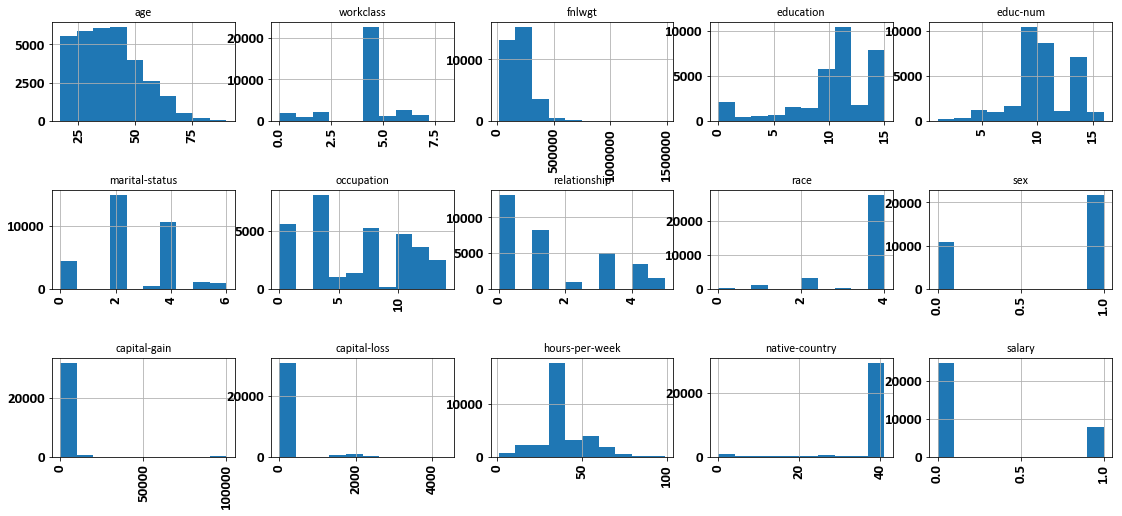

In [240]:
fig = plt.figure(figsize=(19,8))
cols = 5
rows = np.ceil(float(encoded_data.shape[1]) / cols)
for i, column in enumerate(encoded_data.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    encoded_data[column].hist(axes=ax)
    plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

### Матрица корреляций

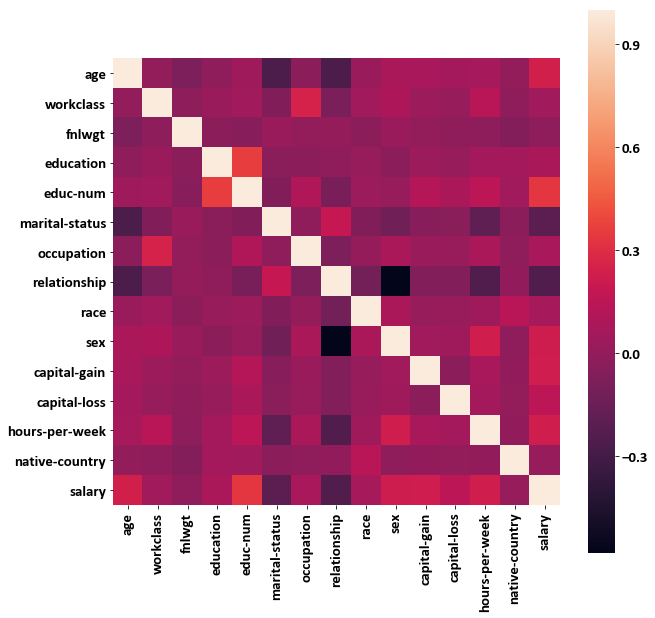

In [241]:
plt.subplots(figsize=(10,10))
encoded_data, encoders = number_encode_features(df)
sns.heatmap(encoded_data.corr(), square=True)
plt.show()

** Вопрос: **
    * Почему не всегда хорошо размечать пропуски аналогично известным значениям атрибутов

В данном датасете пропущенные значения обозначены как " ?".  Удалим из выборки все объекты с пропусками.

In [242]:
df.replace(' ?', np.nan).groupby('workclass').count()[['salary']].index
#df[df['workclass']=='?'].head()

Index([' Federal-gov', ' Local-gov', ' Never-worked', ' Private',
       ' Self-emp-inc', ' Self-emp-not-inc', ' State-gov', ' Without-pay'],
      dtype='object', name='workclass')

In [243]:
df.replace(' ?', np.nan, inplace=True)
print(df.shape)
df.count()

(32560, 15)


age               32560
workclass         30724
fnlwgt            32560
education         32560
educ-num          32560
marital-status    32560
occupation        30717
relationship      32560
race              32560
sex               32560
capital-gain      32560
capital-loss      32560
hours-per-week    32560
native-country    31977
salary            32560
dtype: int64

Видим, что признаки workclass, occupation и naitove-country имеют пропуски. Удалим все объекты с пропусками из выборки

In [244]:
df = df.dropna()
df.count()

age               30161
workclass         30161
fnlwgt            30161
education         30161
educ-num          30161
marital-status    30161
occupation        30161
relationship      30161
race              30161
sex               30161
capital-gain      30161
capital-loss      30161
hours-per-week    30161
native-country    30161
salary            30161
dtype: int64

** Вопрос: **
    * Почему не всегда правильно использовать перекодированные категориальные признаки (на примере kNN)?
    
** Предобработка данных: **
     - разметка целевой переменной
     - оставляем только числовые признаки

In [245]:
df_prc = df.copy()
df_prc['salary'] = df['salary'].apply((lambda x: x==' >50K'))
df_prc.head()

,age,workclass,fnlwgt,education,educ-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,False
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,False
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,False
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,False
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,False


In [246]:
# числовые признаки
df._get_numeric_data().columns

Index(['age', 'fnlwgt', 'educ-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')

In [247]:
# Найдём категориальные признаки
Categorical_cols = list(set(df.columns)- set(df._get_numeric_data().columns))
Categorical_cols

['relationship',
 'salary',
 'education',
 'workclass',
 'marital-status',
 'race',
 'sex',
 'native-country',
 'occupation']

In [248]:
X = np.array(df_prc[df._get_numeric_data().columns])
# y = np.array(df_prc['salary'], dtype='int')
y = encoders['salary'].transform(df['salary'])

------------------------------
# Масштабирование признаков

** Вопрос** 
* Почему для данного датасета может быть полезно привести все признаки к значениями от 0 до 1, для того чтобы использовать kNN в качестве классификатора? 

В качестве классификатора используем kNN, признаки: число соседей (*n_neighbors*) и метрика (*metrics*).


Подберём оптимальные значения указанных гиперпараметров

In [249]:
def grid_plot(x, y, x_label, title, y_label='roc_auc'):
    plt.figure(figsize=(12, 6))
    plt.grid(True)
    plt.plot(x, y, 'go-')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

In [250]:
knn = KNeighborsClassifier()

### Подбор параметра n_neighbors для KNeighborsClassifier

In [251]:
knn_grid = {'n_neighbors': np.array(np.linspace(2, 100, 10), dtype='int')}
gs = GridSearchCV(knn, knn_grid, cv=5)
gs.fit(X, y)

GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': array([  2,  12,  23,  34,  45,  56,  67,  78,  89, 100])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

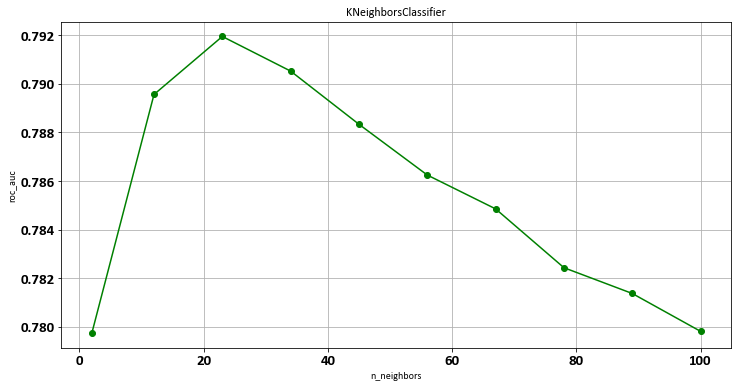

In [252]:
grid_plot(knn_grid['n_neighbors'], gs.cv_results_['mean_test_score'], 'n_neighbors', 'KNeighborsClassifier')

In [253]:
knn_grid = {'n_neighbors': np.array(np.linspace(15, 35, 11), dtype='int')}
gs = GridSearchCV(knn, knn_grid, cv=10)
gs.fit(X, y)
gs.best_params_, gs.best_score_

({'n_neighbors': 27}, 0.7923808892278108)

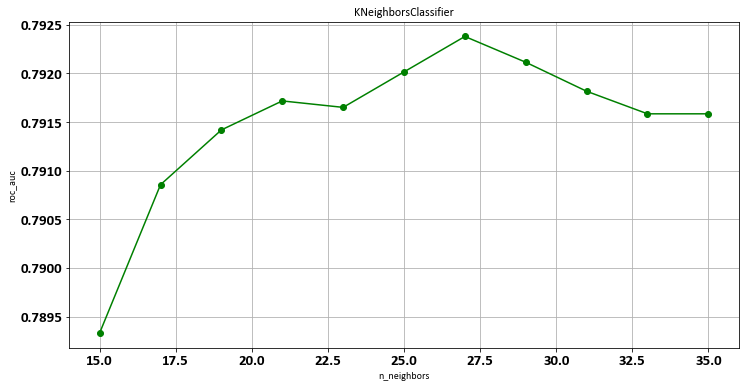

In [254]:
grid_plot(knn_grid['n_neighbors'], gs.cv_results_['mean_test_score'], 'n_neighbors', 'KNeighborsClassifier')

Масштабирование признаков можно выполнить, например, одним из следующих способов способами:
 - $x_{new} = \dfrac{x - \mu}{\sigma}$, где $\mu, \sigma$ — среднее и стандартное отклонение значения признака по всей выборке (см. функцию [scale](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html))
 - $x_{new} = \dfrac{x - x_{min}}{x_{max} - x_{min}}$, где $[x_{min}, x_{max}]$ — минимальный интервал значений признака

In [152]:
from sklearn.preprocessing import scale
X_scaled = scale(np.array(X, dtype='float'), with_std=True, with_mean=False)

In [153]:
X_scaled

array([[ 2.85919077,  0.73441219,  5.05309476,  0.29437338,  0.        ,
         3.23959063],
       [ 3.6656292 ,  0.78931594,  5.05309476,  0.        ,  0.        ,
         1.05286695],
       [ 2.78587819,  2.04310144,  3.49829637,  0.        ,  0.        ,
         3.23959063],
       ..., 
       [ 4.25212987,  1.43924552,  3.49829637,  0.        ,  0.        ,
         3.23959063],
       [ 1.61287685,  1.90898282,  3.49829637,  0.        ,  0.        ,
         1.61979531],
       [ 3.81225436,  2.72791551,  3.49829637,  2.03434482,  0.        ,
         3.23959063]])

### Подборка параметра n_neighbors для KNeighborsClassifier при нормированных признаках

{'n_neighbors': 67} 0.822087773717


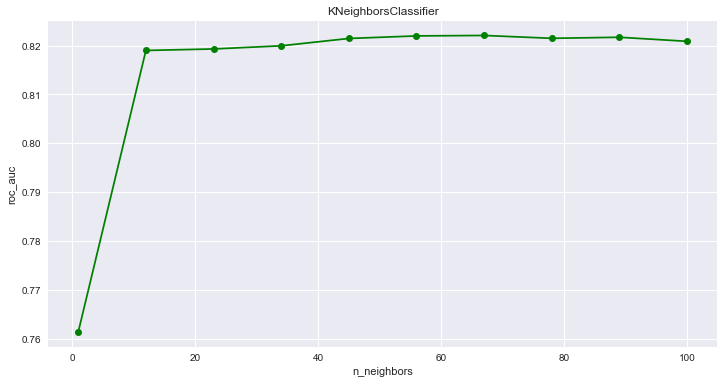

In [161]:
grid = {'n_neighbors': np.array(np.linspace(1, 100, 10), dtype='int')}
gs = GridSearchCV(knn, grid, cv=5, n_jobs=5)
gs.fit(X_scaled, y)
print(gs.best_params_, gs.best_score_)
grid_plot(grid['n_neighbors'], gs.cv_results_['mean_test_score'], 'n_neighbors', 'KNeighborsClassifier')

{'n_neighbors': 59} 0.822916986579


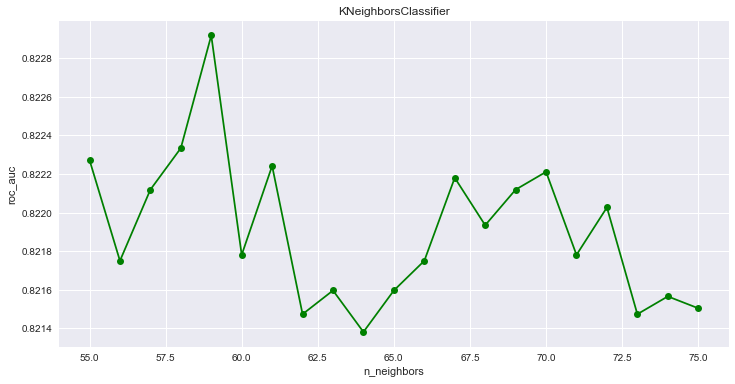

In [164]:
# grid = {'n_neighbors': np.array(np.linspace(55, 75, 21), dtype='int')}
# gs = GridSearchCV(knn, grid, cv=10, n_jobs=5)
# gs.fit(X_scaled, y)
print(gs.best_params_, gs.best_score_)
grid_plot(grid['n_neighbors'], gs.cv_results_['mean_test_score'], 'n_neighbors', 'KNeighborsClassifier')

** Вопрос ** 
 * Увеличилась ли точность классификации после нормировки?

## Добавление категориальных признаков в модели
** Вопрос **
* Как добавить категориальные признаки?

In [119]:
df._get_numeric_data().columns

Index(['age', 'fnlwgt', 'educ-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')

In [120]:

df_cat = pd.concat([pd.DataFrame(X, columns=df._get_numeric_data().columns), pd.get_dummies(df_prc[['education', 'marital-status', 'occupation', 'relationship', 'race', 'sex']]) ],
          axis=1)
df_cat.head()

,age,fnlwgt,educ-num,capital-gain,capital-loss,hours-per-week,education_ 10th,education_ 11th,education_ 12th,education_ 1st-4th,...,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,race_ Amer-Indian-Eskimo,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,sex_ Female,sex_ Male
0,50.0,83311.0,13.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,38.0,215646.0,9.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,53.0,234721.0,7.0,0.0,0.0,40.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,28.0,338409.0,13.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,37.0,284582.0,14.0,0.0,0.0,40.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


<h1 align="center"> Метрики </h1> 
# Метрики для задачи классификации
### Accuracy

### Поделим выборку на train/test

In [123]:
X_train, X_test, y_tain, y_test = train_test_split(X,y, test_size=0.33, random_state=42)

### Используем 2 классификаторва 
- умный kNN
- глупый -- DummyClassifier (самый популярный класс)

In [124]:
knn = KNeighborsClassifier(n_neighbors=29) 
clf_knn = knn.fit(X_train, y_tain)
clf_mp = dummy.DummyClassifier("most_frequent").fit(X_train, y_tain)

In [125]:
y_knn = clf_knn.predict(X_test)
y_mp = clf_mp.predict(X_test)

In [128]:
y_knn

array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

In [129]:
y_mp

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [130]:
y_test

array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

### $$Accuracy = \frac{\sum_{x_i, y_i \in (X, Y)} I(y(x_i) = y_i)}{|(X, Y)|} = \frac{num~right~classified~obj}{num~all~obj}$$

In [131]:
print ('knn =', metrics.accuracy_score(y_test, y_knn), 'mp =', metrics.accuracy_score(y_test, y_mp))

knn = 0.7936507936507936 mp = 0.755877034358047


** Вопросы **
* На самом ли деле kNN выдает настолько плох?
* Какую использовать метрику точности предсказаний при несбалансированных классах?

### Conf-matrix

Text(0.5,43,'Predicted value')

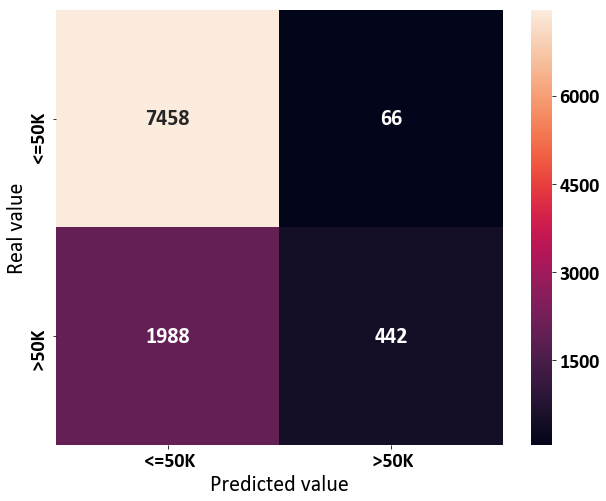

In [135]:
fig = plt.figure(figsize=(10,8))
nn_mtx = metrics.confusion_matrix(y_test, y_knn)

font = {'family' : 'Calibri', 'weight' : 'bold', 'size'   :22}
matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
sns.heatmap(nn_mtx, annot=True, fmt="d", 
            xticklabels=encoders["salary"].classes_, 
            yticklabels=encoders["salary"].classes_)
plt.ylabel("Real value")
plt.xlabel("Predicted value")

### Precision

## $$Precision = \frac{TP}{TP + FP}$$

In [138]:
print ('knn =', metrics.precision_score(y_test, y_knn), 'mp =', metrics.precision_score(y_test, y_mp))

knn = 0.8700787401574803 mp = 0.0


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


** Вопрос: **
* Приведите пример работы классификатора когда precition большой а классификатор работает плохо?

### Recall

## $$Recall = \frac{TP}{TP + FN}$$

In [139]:
print ('knn =', metrics.recall_score(y_test, y_knn), 'mp =', metrics.recall_score(y_test, y_mp))

knn = 0.18189300411522633 mp = 0.0


** Вопрос: ** 
* Приведите пример работы классификатора когда recall большой а классификатор работает плохо?

### F1

Что важнее, точность или полнота? Какое среднее выбрать?

## $$F1 = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}$$

** Вопросы: ** 
* Как взвесить Precision и Recall?
    - Среднее арифметичиское плохо: (p=0.5, r=0.5) должно быть лучше чем (p=1, r=0), 
    - Лучше минимум, но при равной точности должен побеждать классфикатор с большей полнотой
    - Гармоничиское среднее, сглаженный минимум

Text(0,0.5,'Recall')

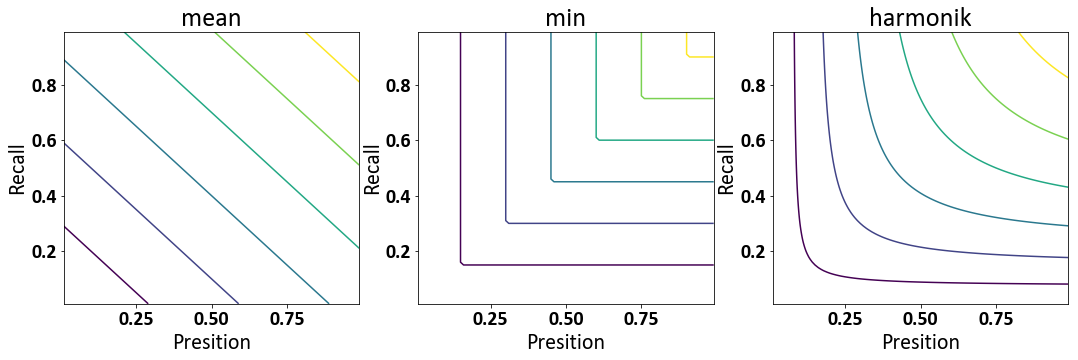

In [140]:
fig, axs = plt.subplots(figsize=(18, 5), ncols=3)

x_, y_ = np.arange(0.01, 1, 0.01), np.arange(0.01, 1, 0.01)
X, Y = np.meshgrid(x_, y_)

Z = [[0.5*x + 0.5*y  for x in x_] for y in y_]
axs[0].contour(X, Y, Z)
axs[0].set_title('mean')
axs[0].set_xlabel('Presition')
axs[0].set_ylabel('Recall')

Z = [[min(x, y)  for x in x_] for y in y_]
axs[1].contour(X, Y, Z)
axs[1].set_title('min')
axs[1].set_xlabel('Presition')
axs[1].set_ylabel('Recall')


Z = [[scipy.stats.hmean([x, y])  for x in x_] for y in y_]
axs[2].contour(X, Y, Z)
axs[2].set_title('harmonik')
axs[2].set_xlabel('Presition')
axs[2].set_ylabel('Recall')

In [141]:
print ('knn =', metrics.f1_score(y_test, y_knn), 'mp =', metrics.f1_score(y_test, y_mp))

knn = 0.3008849557522124 mp = 0.0


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


# <span style="color:orange"> Multiclass Precision-Recall </span>(опционально)

#### Загрузим датасет с тремя классами

In [211]:
from sklearn.datasets import load_iris
load_iris = load_iris()
df_iris = pd.DataFrame(load_iris.data, columns=load_iris.feature_names)
iris_spec_list = [load_iris.target_names[i] for i in load_iris.target]
df_iris_spec = pd.DataFrame(iris_spec_list, columns=['species'])
df_iris = pd.concat([df_iris, df_iris_spec], axis=1)
df_iris[:150:30]

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
30,4.8,3.1,1.6,0.2,setosa
60,5.0,2.0,3.5,1.0,versicolor
90,5.5,2.6,4.4,1.2,versicolor
120,6.9,3.2,5.7,2.3,virginica


In [212]:
#df_iris = sns.load_dataset("iris")
#df_iris = df_iris.sample(n=150)

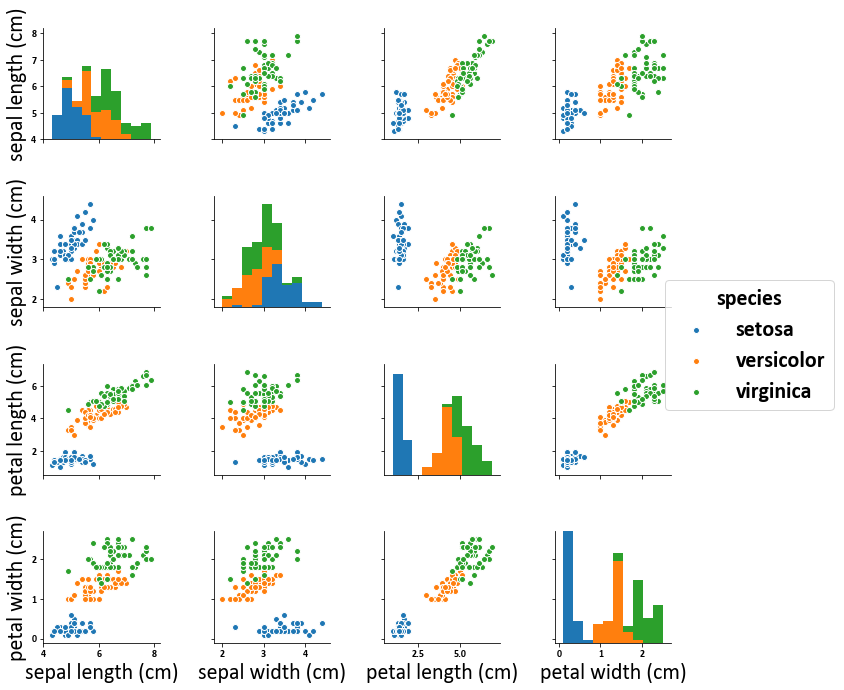

In [213]:
matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=10)
sns.pairplot(df_iris, hue="species")

In [214]:
df_iris, encoders = number_encode_features(df_iris)
iris_X, iris_y = df_iris[df_iris.columns[:-1]].values, df_iris[df_iris.columns[-1]].values

from sklearn.utils import shuffle
iris_X, iris_y = shuffle(iris_X, iris_y)

iris_X_train, iris_y_tain = iris_X[:30], iris_y[:30]
iris_X_test, iris_y_test = iris_X[40:], iris_y[40:]

In [215]:
df_iris.head()
df_iris[:150:30]
encoders

{'species': LabelEncoder()}

In [216]:
iris_clf_knn = KNeighborsClassifier().fit(iris_X_train, iris_y_tain)
iris_clf_mp = dummy.DummyClassifier("most_frequent").fit(iris_X_train, iris_y_tain)

In [217]:
iris_y_knn = iris_clf_knn.predict(iris_X_test)
iris_y_mp = iris_clf_mp.predict(iris_X_test)

Пусть выборка состоит из K классов. Рассмотрим K двухклассовых задач, каждая из которых заключается в отделении своего класса от остальных, то есть целевые значения для k-й задаче вычисляются как $y_{ik} = [yi = k]$. Для каждой из них можно вычислить различные характеристики (TP, FP, и т.д.) алгоритма $a_k(x) = [a(x) = k]$.

Text(0.5,48,'Predicted value')

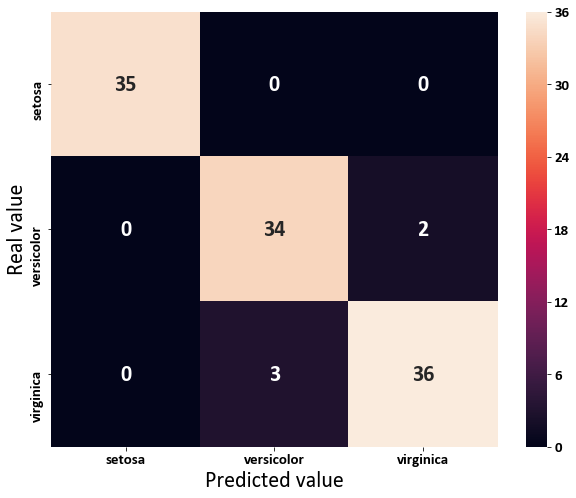

In [218]:
mp_mtx = metrics.confusion_matrix(iris_y_test, iris_y_knn)

fig = plt.figure(figsize=(10,8))
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)
sns.heatmap(mp_mtx, annot=True, fmt="d", 
            xticklabels=encoders["species"].classes_, 
            yticklabels=encoders["species"].classes_)
plt.ylabel("Real value")
plt.xlabel("Predicted value")

**Macro-averaging** -- подсчет TP, FN, TN, FP для каждого класса, а после подсчет точности и полноты.

**Micro-averaging** -- подсчет  точности и полноты для каждого класса, а после подсчет их среденего.

In [219]:
print('для kNN:')
print ('macro = ', metrics.f1_score(iris_y_test, iris_y_knn, average='macro'), ', micro = ', metrics.f1_score(iris_y_test, iris_y_knn, average='micro'))

# 
print('\nдля dummy-classifier:')
iris_y_knn[iris_y_knn==1] = 0
print ('macro = ', metrics.f1_score(iris_y_test, iris_y_knn, average='macro'), ', micro = ', metrics.f1_score(iris_y_test, iris_y_knn, average='micro'))

для kNN:
macro =  0.9555239281266679 , micro =  0.9545454545454546

для dummy-classifier:
macro =  0.5297568475138569 , micro =  0.6454545454545455


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# AUC-ROC

In [220]:
clf_knn = neighbors.KNeighborsClassifier(n_neighbors=29).fit(X_train, y_tain)
clf_mp = dummy.DummyClassifier("most_frequent").fit(X_train, y_tain)

In [221]:
y_knn = clf_knn.predict(X_test)
y_mp = clf_mp.predict(X_test)

ROC AUC = 0.5866


Text(0.5,0,'False Positive Rate')

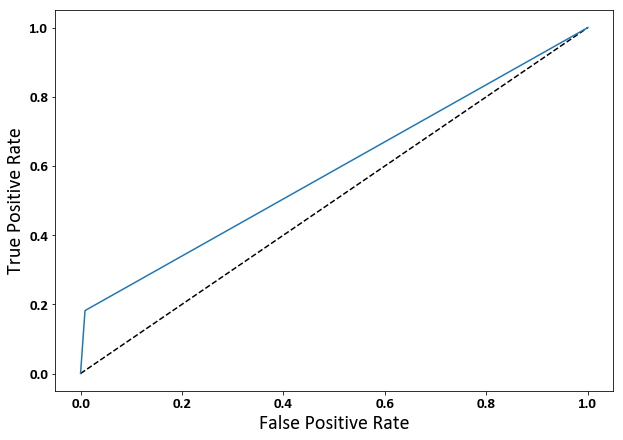

In [222]:
fpr, tpr, _ = metrics.roc_curve(y_test, y_knn)
pylab.figure(figsize=(10, 7))
pylab.plot([0, 1], [0, 1], 'k--')
pylab.plot(fpr, tpr)
print ('ROC AUC = {0:.4f}'.format(metrics.auc(fpr, tpr)))
plt.ylabel("True Positive Rate", fontsize=20)
plt.xlabel("False Positive Rate", fontsize=20)

ROC AUC = 0.5000


Text(0.5,0,'False Positive Rate')

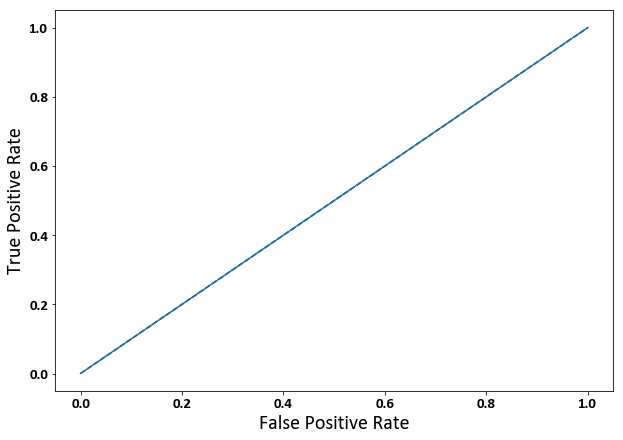

In [223]:
fpr, tpr, _ = metrics.roc_curve(y_test, y_mp)
pylab.figure(figsize=(10, 7))
pylab.plot([0, 1], [0, 1], 'k--')
pylab.plot(fpr, tpr)
print ('ROC AUC = {0:.4f}'.format(metrics.auc(fpr, tpr)))
plt.ylabel("True Positive Rate", fontsize=20)
plt.xlabel("False Positive Rate", fontsize=20)

** Вопрос **
* Когда AUC большой при плохой работе классификатора?

# PR AUC

PR AUC = 0.3817


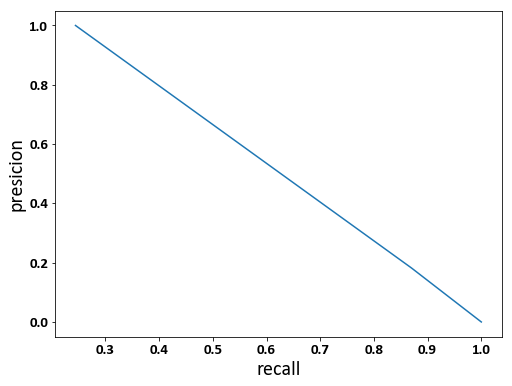

In [224]:
pres, rec, _ = metrics.precision_recall_curve(y_test, y_knn)
pylab.figure(figsize=(8, 6))
pylab.plot(pres, rec)
pylab.ylabel('presicion', fontsize=20)
pylab.xlabel('recall', fontsize=20)
print ('PR AUC = {0:.4f}'.format(metrics.auc(pres, rec)))

In [225]:
pres, rec

(array([0.24412297, 0.87007874, 1.        ]),
 array([1.      , 0.181893, 0.      ]))

PR AUC = 0.3779


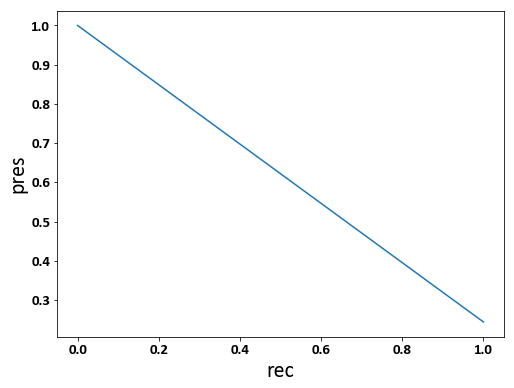

In [226]:
pres, rec, _ = metrics.precision_recall_curve(y_test, y_mp)
pylab.figure(figsize=(8, 6))
pylab.plot(rec, pres)
pylab.ylabel('pres')
pylab.xlabel('rec')
print( 'PR AUC = {0:.4f}'.format(metrics.auc(pres, rec)))

Когда PR кривая не адекватна?

# Метрики для задачи рагрессии

Data: https://archive.ics.uci.edu/ml/datasets/Wine+Quality

In [93]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv', header=0, sep=';')

In [94]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


<function print>

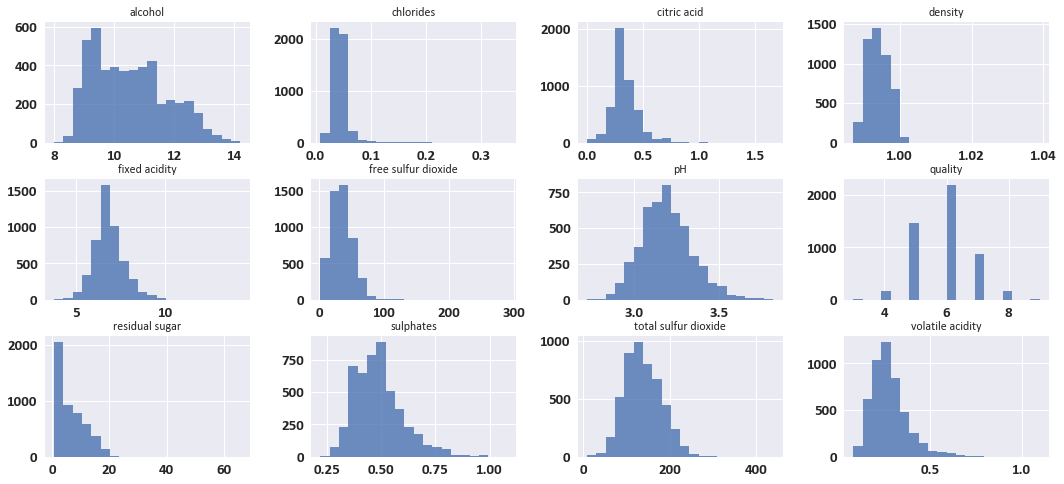

In [95]:
df.hist(figsize=(18, 8), layout=(3,4), bins=20, alpha=0.8)
print 

In [96]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('quality', axis=1), df.quality, test_size=0.33, random_state=42)

In [97]:
X_train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
3167,5.6,0.28,0.40,6.1,0.034,36.0,118.0,0.99144,3.21,0.43,12.1
324,8.3,0.41,0.51,2.0,0.046,11.0,207.0,0.99300,3.02,0.55,11.4
4731,5.3,0.31,0.38,10.5,0.031,53.0,140.0,0.99321,3.34,0.46,11.7
2305,7.0,0.36,0.30,5.0,0.040,40.0,143.0,0.99173,3.33,0.42,12.2
1777,6.5,0.18,0.26,1.4,0.041,40.0,141.0,0.99410,3.34,0.72,9.5


In [98]:
y_train.head()

3167    7
324     5
4731    6
2305    7
1777    6
Name: quality, dtype: int64

In [100]:
print (X_train.shape, X_test.shape)
print (y_train.shape, y_test.shape)

(3281, 11) (1617, 11)
(3281,) (1617,)


In [101]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [102]:
# Create dummy regression object
d_regr = dummy.DummyRegressor(strategy='mean')

# Train the model using the training sets
d_regr.fit(X_train, y_train)

DummyRegressor(constant=None, quantile=None, strategy='mean')

In [103]:
predictions = regr.predict(X_test)

In [104]:
d_predictions = d_regr.predict(X_test)

In [106]:
print (predictions.shape, '\t', predictions[0:5])

(1617,) 	 [ 6.37886848  6.3994996   6.40362171  5.82459689  6.45383134]


In [107]:
print (d_predictions.shape, '\t', d_predictions[0:5])

(1617,) 	 [ 5.86863761  5.86863761  5.86863761  5.86863761  5.86863761]


(array([ 0.00944673,  0.01417009,  0.00944673,  0.02834018,  0.04251027,
         0.03306354,  0.04723363,  0.12280745,  0.12280745,  0.11808409,
         0.13225418,  0.18893454,  0.27395508,  0.35425226,  0.45816626,
         0.42510271,  0.46761298,  0.50067653,  0.48178307,  0.55735689,
         0.63765407,  0.5431868 ,  0.54791016,  0.42982608,  0.34008217,
         0.23616817,  0.1417009 ,  0.08502054,  0.07557382,  0.03778691,
         0.04723363,  0.01889345,  0.02834018,  0.02361682,  0.01417009,
         0.00472336,  0.01417009,  0.00472336,  0.        ,  0.        ,
         0.        ,  0.00472336,  0.        ,  0.00472336,  0.00472336,
         0.        ,  0.        ,  0.        ,  0.        ,  0.00472336]),
 array([-2.45820085, -2.32727102, -2.19634119, -2.06541135, -1.93448152,
        -1.80355169, -1.67262186, -1.54169202, -1.41076219, -1.27983236,
        -1.14890252, -1.01797269, -0.88704286, -0.75611303, -0.62518319,
        -0.49425336, -0.36332353, -0.23239369, -0

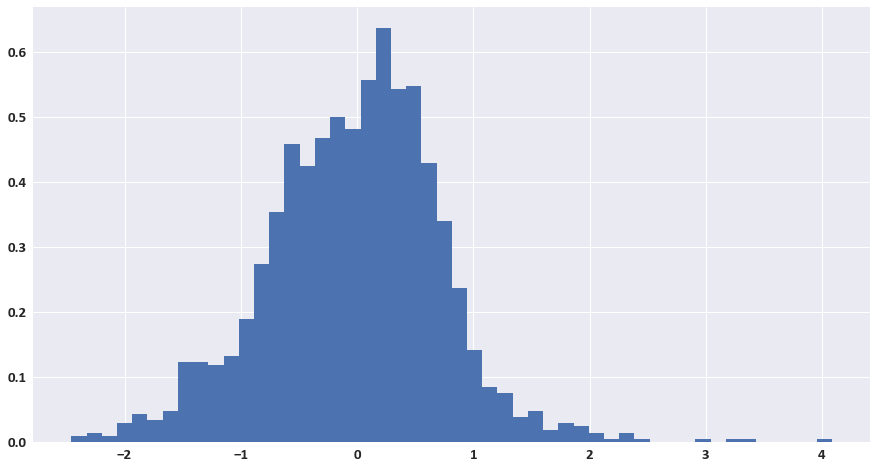

In [109]:
rem = predictions - y_test
pylab.figure(figsize=(15, 8))
plt.hist(rem, bins=50, normed=True)

### Mean Square Error 

## $$ MSE(y, \hat y) = \frac{1}{n_{samples}} \sum_{i=1}^{n_{samples}} ( y_i - \hat y_i )^2 $$

In [111]:
mse = metrics.mean_squared_error(y_test, predictions)
d_mse = metrics.mean_squared_error(y_test, d_predictions)

print ("MSE,  LR = {0:.4}, Dummy = {1:0.4}".format(mse, d_mse))

MSE,  LR = 0.5576, Dummy = 0.7638


In [112]:
rmse = np.sqrt(mse)
d_rmse = np.sqrt(d_mse)

print( "RMSE / LR = {0:.4}, Dummy = {1:0.4}".format(rmse, d_rmse))

RMSE / LR = 0.7467, Dummy = 0.8739


### Mean Absolute Error 

## $$ MAE(y, \hat y) = \frac{1}{n_{samples}} \sum_{i=1}^{n_{samples}} | y_i - \hat y_i | $$

In [113]:
mae = metrics.mean_absolute_error(y_test, predictions)
d_mae = metrics.mean_absolute_error(y_test, d_predictions)

print( "MAE / LR = {0:.4}, Dummy = {1:0.4}".format(mae, d_mae))

MAE / LR = 0.5806, Dummy = 0.6663


### Median Absolute Error 

## $$ MedAE(y, \hat y) = median( | y_1 - \hat y_1 |, ..., | y_n - \hat y_n | ) $$

In [115]:
medae = metrics.median_absolute_error(y_test, predictions)
d_medae = metrics.median_absolute_error(y_test, d_predictions)

print ("MedAE / LR = {0:.4}, Dummy = {1:0.4}".format(medae, d_medae))

MedAE / LR = 0.481, Dummy = 0.8686


### R² score, the coefficient of determination

## $$ R^2(y, \hat y) = 1 -  \frac{\sum_{i=1}^{n_{samples}} ( y_i - \hat y_i )^2}{\sum_{i=1}^{n_{samples}} {( y_i - \bar y_i )^2}} $$

## $ \bar y = \frac{1}{n_{samples}} \sum_{i=1}^{n_{samples}} y_i $

In [117]:
r2 = metrics.r2_score(y_test, predictions)
d_r2 = metrics.r2_score(y_test, d_predictions)

print ("R2 score / LR = {0:.4}, Dummy = {1:0.4}".format(r2, d_r2))

R2 score / LR = 0.2692, Dummy = -0.001034


<b>Как интерпретировать MSE, RMSE, MAE, MedAE?</b>

# Интепретация метрик с вероятностной точки зрения

#### Функционал среднего риска
$$R(a) = \sum\limits_{X}\sum\limits_{Y}\lambda_{ya(x)}P\left(y|x\right)p(x)dx=\int\limits_{X}\sum\limits_{Y}\lambda_{ya(x)}P\left(y|x\right)p(x)dx $$
* paragraph 2.1 http://www.machinelearning.ru/wiki/images/6/6d/Voron-ML-1.pdf

** Задача 1** 
<img src='img/Task2.png'>

** Задача 2** 
<img src='img/Task3.png'>

<h1 align="center"> Bias-Variance TradeOff </h1> 
# Проблема переобучения

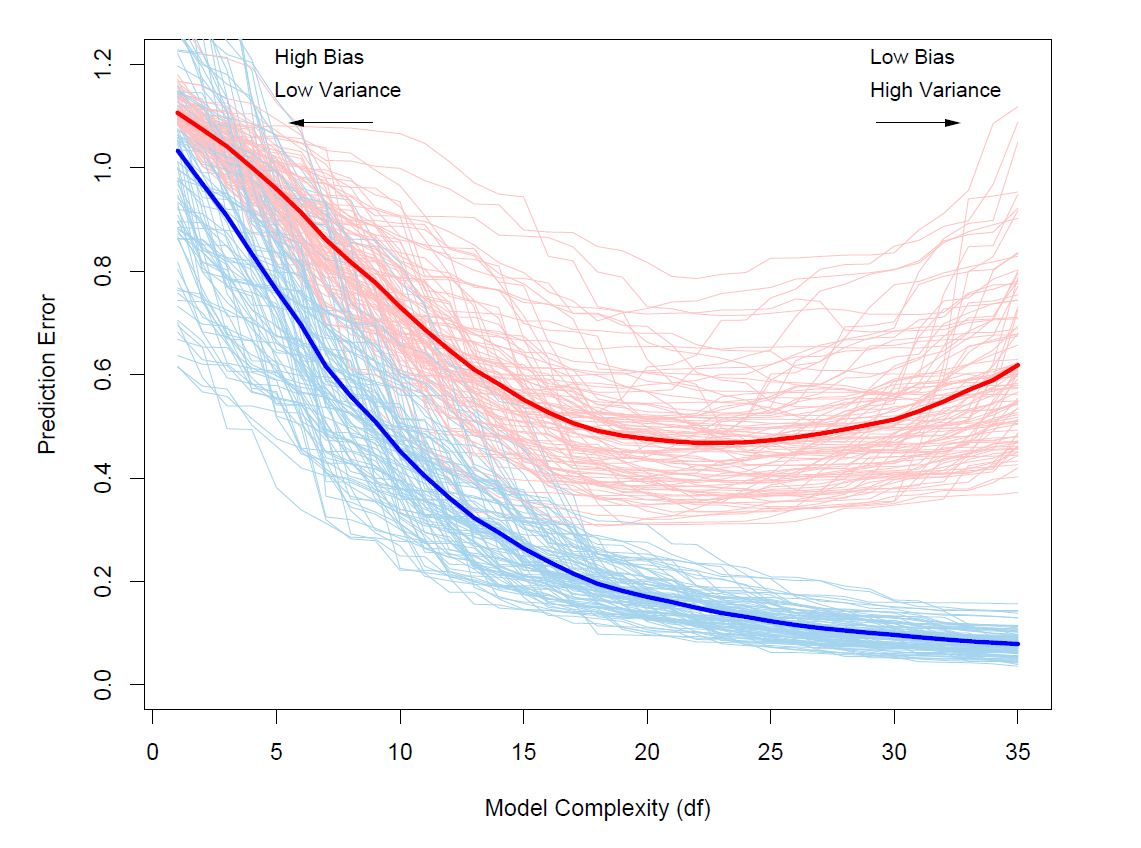

In [51]:
# Overfitting 
Image('pic/CV.jpg', width=700, height=500)

<span style='color: blue, font-size=12pt'> Learing Sample = Train Set = Обучающая выборка </span>  VS
<span style='color: red, font-size=12pt'> Validation Sample = Validation Set = Контрольная выборка </span>

<span style='color: green, font-size=12pt'> Переобучение - это явление (эффект), связанное с тем, что с ростом сложности семейства алгоритмов будет ухудшаться (с некоторого момента), точность на контрольной выборке.</span>

** Вопросы **
 * В чём причина переобучения?
 * Можно ли ожидать, что с ростом сложности модели ошибка на контрольной (велидационной) выборке будет только расти (неуменьшаться)?

# Идея разложения ошибки на bias и variance

** Bias Variance Idea **
   * Given a model $a_{LS}$ built from learning sample $LS$.
    - Its generalization error (useful for model assessment):
$$ Err_{LS}=E_{X,Y}\{\mathcal L(y, a_{LS})\}$$

   * Given a learning algorithm $\mu$ trained on $LS$ of size $\ell$
     - Its error (useful to describe learning algorithm):
    $E_{LS} {Err_{LS} }=E_{LS} \left\{E_{X,Y}\{\mathcal L(y, a_{LS})\}\right\}$

<img src='img/BVIdea.jpg', Width=600>

## БЮВывод для регрессии при квадратичной функции потерь  
* simple regression model $Err_{LS} = E_y \left\{(y-\hat{y})^2\right\}$:
* a good algorithm should minimize an error not only on one $LS$, but in average over all $LS$ of size $\ell$:

\begin{equation}
    \begin{split}
        &  E_{LS} \left\{E_{Y}\{(y - \hat{y})^2\}\right\} = E_{LS} \left\{E_{Y}\{(y - E_Y\{y\} + E_Y\{y\} - \hat{y})^2\}\right\} = \\
          = & E_{LS} \left\{E_{Y}\{(y - E_Y\{y\})^2\}\right\} + E_{LS} \left\{E_{Y}\{(E_Y\{y\} - \hat{y})^2\}\right\}+
        2 E_{LS} \left\{E_{Y}\{(y - E_Y\{y\}) (E_Y\{y\} - \hat{y})\}\right\} = \\
          = & E_{Y}\{(y - E_Y\{y\})^2\} + E_{LS} \left\{(E_Y\{y\} - \hat{y})^2\right\}
        + 2 E_{LS} \left\{E_{Y}\{(y - E_Y\{y\}) (E_Y\{y\} - \hat{y})\}\right\} =\\
         & = \color{red}{\underbrace{E_{Y}\{(y - E_Y\{y\})^2\}}_{var_Y\{y\}}} +\color{black}{E_{LS} \left\{(E_Y\{y\} - \hat{y})^2\right\}}
    \end{split}
\end{equation}

\begin{equation}
    \begin{split}
        & E_{LS} \left\{(E_Y\{y\} - \hat{y})^2\right\} = E_{LS} \left\{(E_Y\{y\} - E_{LS}\{\hat{y}\} + E_{LS}\{\hat{y}\} - \hat{y})^2\right\} = \\
        & =E_{LS} \left\{(E_Y\{y\} - E_{LS}\{\hat{y}\})^2\right\} + E_{LS} \left\{(E_{LS}\{\hat{y}\} - \hat{y})^2\right\}
         + E_{LS} \left\{2 (E_Y\{y\} - E_{LS}\{\hat{y}\})(E_{LS}\{\hat{y}\} - \hat{y})\right\} = \\
        & =(E_Y\{y\} - E_{LS}\{\hat{y}\})^2 + E_{LS} \left\{(\hat{y}-E_{LS}\{\hat{y}\})^2\right\} + 2 (E_Y\{y\} - E_{LS}\{\hat{y}\})(E_{LS}\{\hat{y}\} - E_{LS}\{\hat{y}\}) = \\
        & = \color{red}{\underbrace{(E_Y\{y\} - E_{LS}\{\hat{y}\})^2 }_{bias^2}}+ \color{red}{\underbrace{E_{LS} \left\{(\hat{y}-E_{LS}\{\hat{y}\})^2\right\}}_{variance}}
    \end{split}
\end{equation}

* более полная версия для регрессии и knn: https://github.com/ml-mipt/ml-mipt-part1/blob/master/2017/seminars/03-pandas/bias_variance.pdf

** Задача **:
Предсказать средний рост группы 59x , которая поступит на физтех в 2025 году, зная рост всех 59x групп прошлых лет. 

Решение: используется 2 модели

## 1) $$\hat{y}=\frac{1}{l}\sum_{i=1}^l y_i$$
## 2) $$\hat{y}=\frac{\lambda\cdot 180+\sum_{i=1}^l y_i}{\lambda+l}$$

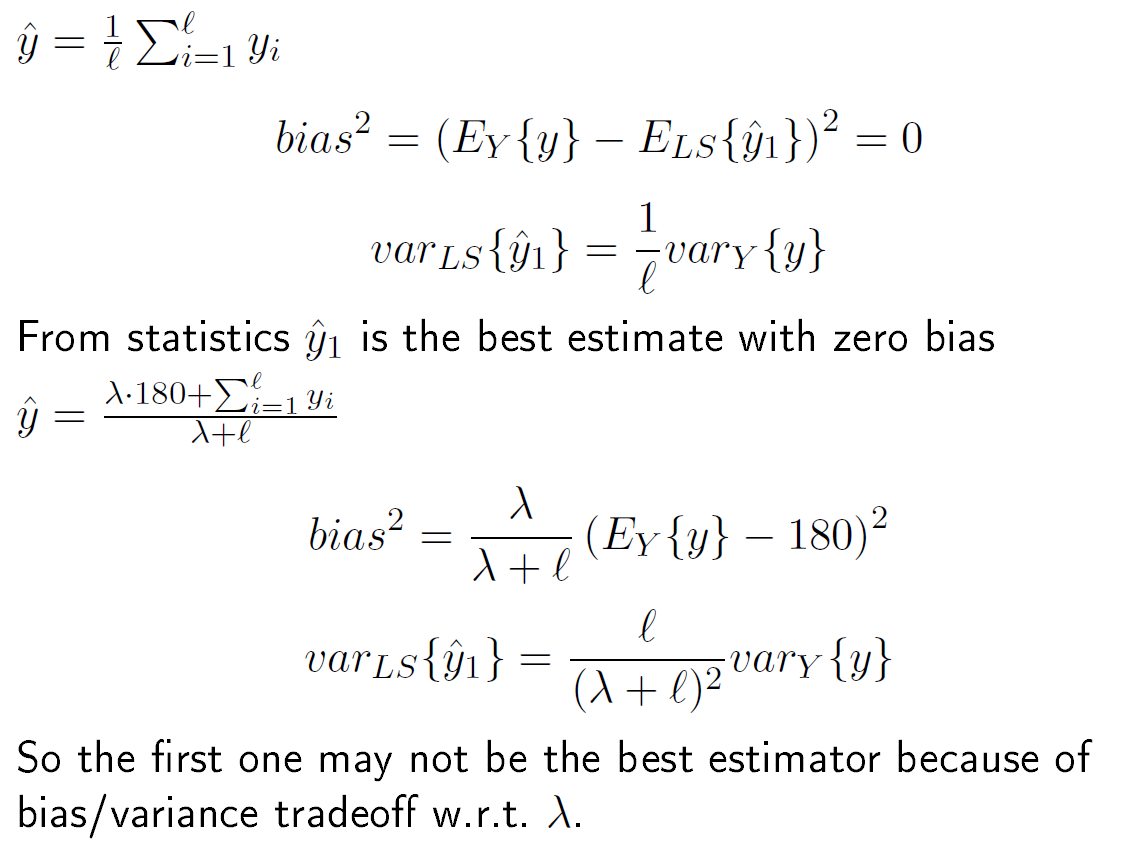

In [62]:
Image('pic/BiasVarianceExample.png', width=500, height=500)

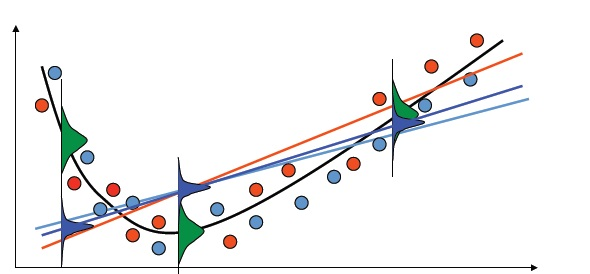

In [63]:
# Underfitting via Bias-Variance approach
Image('pic/Underfitting.jpg')

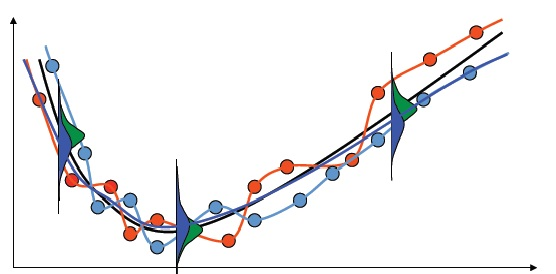

In [65]:
# Overfitting via Bias-Variance approach
Image('pic/Overfitting1.jpg')

------------------------------------
# Bias и Variance

**Bias-Variance ** в зависимости от сложности модели 
<img src='img/BiasVariance.jpg' Width=500>

* ** для kNN** в зависимости от $k$

<img src='img/BV_knn.png', width=500, height=500>


* ** для LR ** в зависимости от размера выборки 
<img src='img/BV_LR.png', width=700, height=700>

<h1 align="center"> Заключение </h1>
* Разные метрики проводят к существенно разным ответам
* Bias-variance tradeoff - один из возможных взглядов на проблему переобучения
    - помогает понять, как работают алгоритмы ML


* <a href = "https://github.com/ml-mipt/ml-mipt-part1/blob/master/2018/hw/hw1/task1.ipynb"> HW#1 <a>
     - <span style='color:blue; font-size:10pt'> Обратите внимание на правила сдачи ДЗ! </span>

# Обратная связь
  * оцените <a href="https://goo.gl/forms/kYZuyAQLuwo8szce2"> семинар </a>
  * оцените <a href="https://goo.gl/forms/zeZiu1fSgrpPGp6T2"> лекцию </a>